In [1]:
#CASO 1: Predicción de la demanda de prdouctos de una empresa, por meses
import pyodbc
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.regularizers import l2
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

plt.rcParams['figure.figsize' ] = (16, 9)
plt.style.use('fast')


In [2]:
sql_server="""
DRIVER={ODBC Driver 17 for SQL Server};
Server=US3RN4M3;
database=demo_prediccion;
Trusted_connection=yes;
"""

In [3]:
# query = """
# SELECT
#     f.OrderDate AS sales_date,
#     SUM(f.SalesAmount) AS TotalVentas
# FROM
#     FactInternetSales AS f
# WHERE
# 	YEAR(f.OrderDate) < 2014
# GROUP BY
#     f.OrderDate
# ORDER BY
#     f.OrderDate DESC;
# """

In [4]:
query = """
SELECT
            SUBSTRING(CAST([F].[Fecha] AS VARCHAR),0,8) AS fecha,
            SUM([H].[cantidad]) AS TotalVentas
            FROM
            [demo_prediccion].[dbo].[hechos] AS [H]
            INNER JOIN [demo_prediccion].[dbo].[Dim_fechas] AS [f] ON [H].[id_DimFechas] = [F].[id]
			WHERE
			[F].[Fecha] < '2020-05-01'
            GROUP BY SUBSTRING(CAST([F].[Fecha] AS VARCHAR),0,8)
            ORDER BY SUBSTRING(CAST([F].[Fecha] AS VARCHAR),0,8) 
"""

In [5]:
query2 = """
SELECT
            SUBSTRING(CAST([F].[Fecha] AS VARCHAR),0,8) AS fecha,
            SUM([H].[cantidad]) AS TotalVentas
            FROM
            [demo_prediccion].[dbo]. [hechos] AS [H]
            INNER JOIN [demo_prediccion].[dbo].[Dim_fechas] AS [f] ON [H].[id_DimFechas] = [F].[id]
            WHERE
			[F].[Fecha] < '2020-05-01'
            GROUP BY SUBSTRING(CAST([F].[Fecha] AS VARCHAR),0,8)
            ORDER BY SUBSTRING(CAST([F].[Fecha] AS VARCHAR),0,8) ASC
"""

In [6]:
#Configuración para el entrenamiento (hace referencia a dias)
PASOS = 12

In [7]:
#Opcion 1: Permitir que pueda ser modificada la sentencia, y mantener el try para evitar de que
# el programa se rompa
def get_sqlconnection(config_sqlServer):
    status = "inicializando...."
    try: 
        connection = pyodbc.connect(sql_server)
        status = "Conexion establecida satisfactoriamente"
    except Exception as e:
        status = "Error al establecer la conexión:"+e
    print(status)
    return connection


In [8]:
def set_index_datetime(data):
        if str(type(data) == "<class 'pandas.core.frame.DataFrame'>"):
            # data.sort_values('fecha', inplace=True)
            for column in data.columns: 
                try: 
                    pd.to_datetime(data[column])
                    data.set_index(column,inplace=True)
                    return data
                except Exception as e:  
                    pass
        else: 
            return 0

In [9]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
def create_x_y_train(data):
    values = data.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values= values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    values = reframed.values
    n_train_periods = int(len(data)) - (30+PASOS)
    print('Los periodos son: ',n_train_periods)
    train = values[:n_train_periods, :]
    test = values[n_train_periods:, :]
    x_train, y_train = train[:, :- 1], train[:, -1]
    x_val, y_val = test[:, :- 1], test[:, -1]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
    return x_train, y_train, x_val, y_val, scaler, values

In [11]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error', optimizer='Adam', metrics=['mse'])
    model.summary()
    return model

In [ ]:
def entrenar_modelo(x_train, y_train, x_val, y_val, scaler, values, data, model):
    EPOCHS = 150
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), batch_size=PASOS, callbacks=[early_stop])
    results=model.predict(x_val)

    #Validaciones #1
    print( len(results) )
    plt.scatter(range(len(y_val)),y_val,c='g', label='Valores Reales')
    plt.scatter(range(len(results)),results,c='r', label='Valores Predichos')
    plt.title('Grafico de rendimiiento #1')
    plt.legend()
    plt.show()

    #Validaciones #2 
    plt.plot(history.history['loss'],label='Pérdida de Entrenamiento')
    plt.title('loss')
    plt.plot(history.history['val_loss'],label='Pérdida de Validación')
    plt.title('Grafico de rendimiiento #2')
    plt.legend()
    plt.show()

    #Validación #3
    plt.title('Grafico de rendimiiento #3')
    plt.plot(history.history['mse'],label='MSE de Entrenamiento')
    plt.legend()
    plt.show()

    ultimosDias = data[data.index[int(len(data)*0.80)]:]
    values = ultimosDias.values
    values = values.astype('float32' )
    values = values.reshape(-1, 1)
    scaled = values
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
    values = ultimosDias.values
    values = values.astype('float32' )
    values = values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
    values = reframed.values
    x_test = values[len(values)-1:, :]
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]) )
    return model, x_test

In [13]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

In [14]:
def eliminar_anomalias(dtaframe):
    dataFrame_anomalias = dtaframe.copy()
    modeloIsolation = IsolationForest(contamination=0.05)
    modeloIsolation.fit(dataFrame_anomalias)
    anomalias = modeloIsolation.predict(dataFrame_anomalias)
    dtaframe['anomalias' ] = anomalias
    dataFrameSinAnomalias = dtaframe[dtaframe['anomalias' ] != -1]
    dataFrameSinAnomalias = dataFrameSinAnomalias.drop('anomalias', axis=1)
    return dataFrameSinAnomalias

In [ ]:
def format_to_date(dates):
    date_format = '%Y-%m-%d'
    status = False
    try: 
        # datetime.strptime(dates['sales_date'],date_format) 
        dates['sales_date'] = pd.to_datetime(dates['sales_date'].str[:10], format='%Y-%m-%d')
        status = True
    except Exception as e: 
        status = False
        return dates

Conexion establecida satisfactoriamente


C:\Users\JoCel\AppData\Local\Temp\ipykernel_4708\2524614818.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  datos = pd.read_sql_query(query, cursor)
C:\Users\JoCel\AppData\Local\Temp\ipykernel_4708\2524614818.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  datos2 = pd.read_sql_query(query2,cursor)


Index(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
       '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04'],
      dtype='object', name='fecha')
         TotalVentas
count      64.000000
mean   403859.640625
std     93084.933643
min    168585.000000
25%    325135.250000
50%    418413.500000
75%    482017.000000
max    602935.

c:\GitHub\pronostico\pronostico\envprediccion\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1, 12)          │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169 (676.00 B)

 Trainable params: 169 (676.00 B)

 Non-trainable params: 0 (0.00 B)

Los periodos son:  18
(18, 1, 12) (18,) (30, 1, 12) (30,)
Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.2769 - mse: 0.1163 - val_loss: 0.3544 - val_mse: 0.2011
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2722 - mse: 0.1111 - val_loss: 0.3605 - val_mse: 0.2063
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2499 - mse: 0.0997 - val_loss: 0.3667 - val_mse: 0.2123
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2453 - mse: 0.0871 - val_loss: 0.3711 - val_mse: 0.2167
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2475 - mse: 0.0928 - val_loss: 0.3715 - val_mse: 0.2171
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2603 - mse: 0.0969 - val_loss: 0.3699 - val_mse: 0.2153
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2498 - mse: 0.0921 - val_loss: 0.3677 - val_mse: 0.2128
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2443 - mse: 0.0877 - val_loss: 0.3640 - val_mse: 0.2088
Epoch 9/150
2

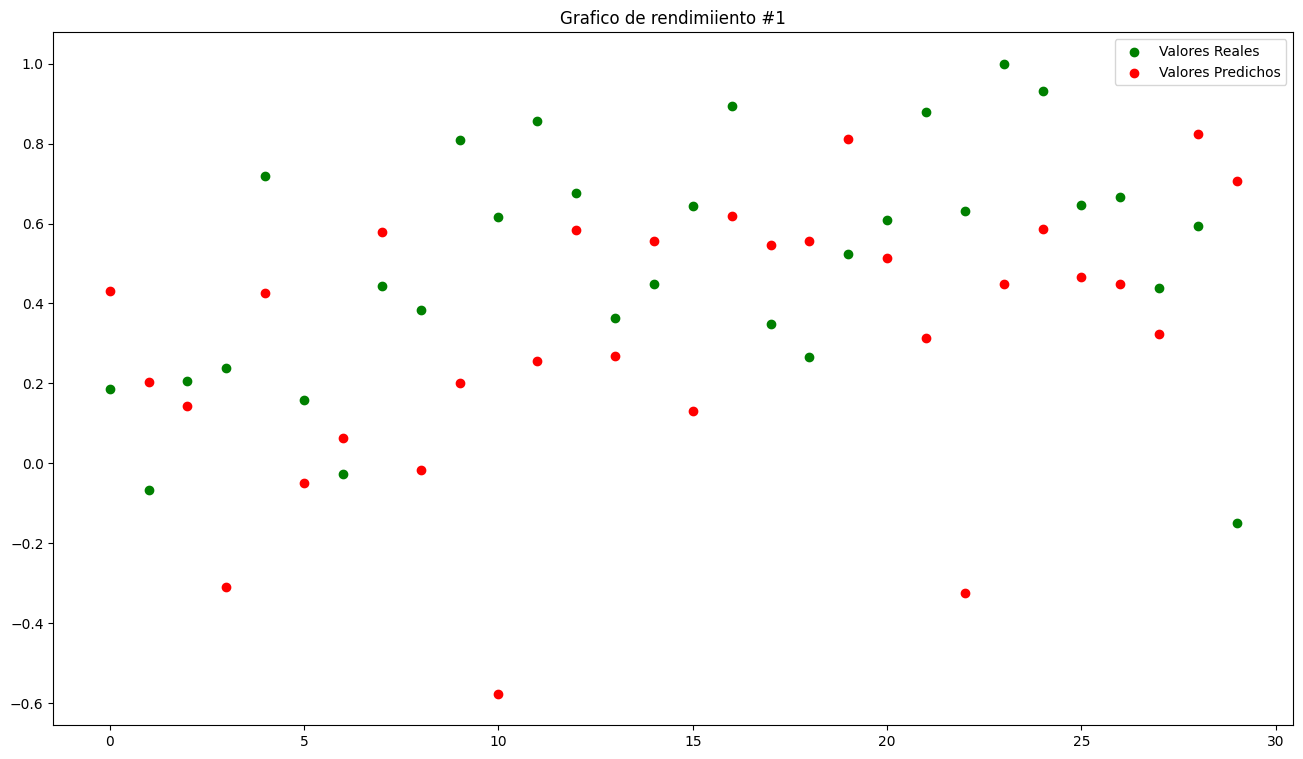

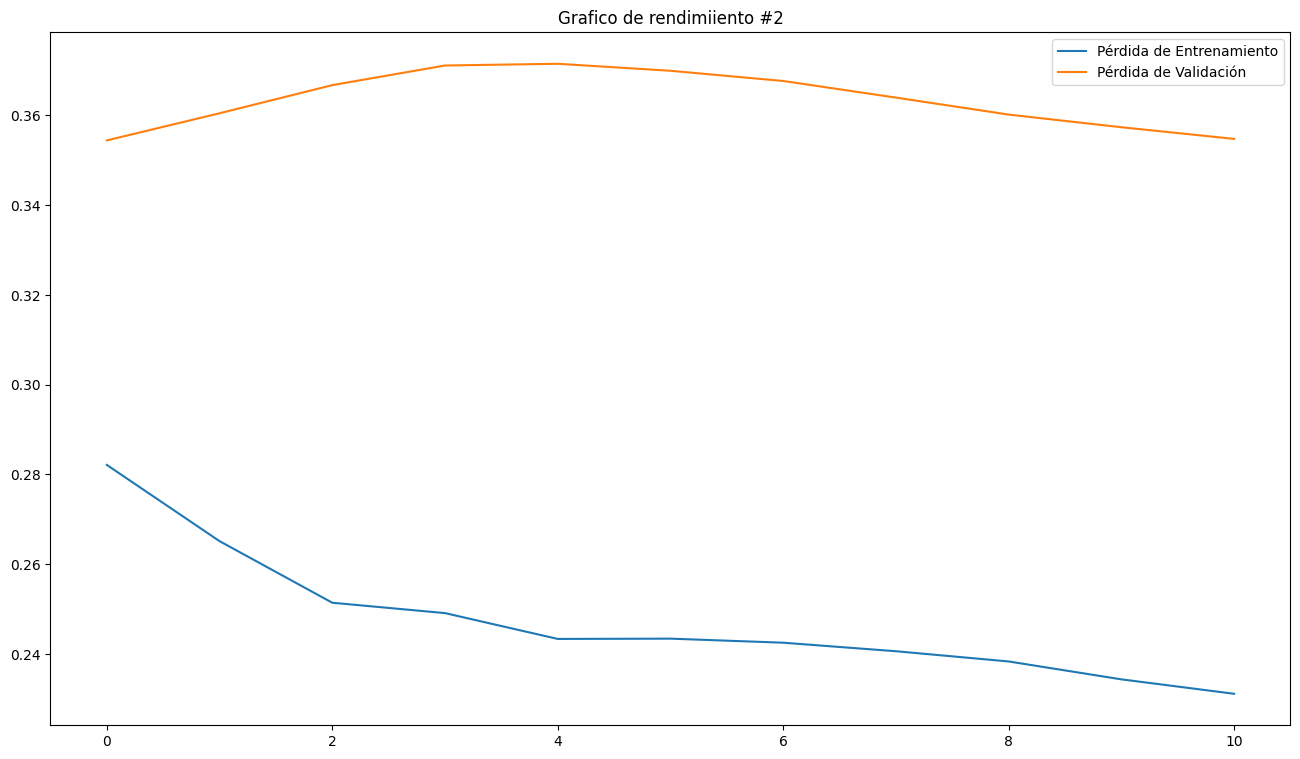

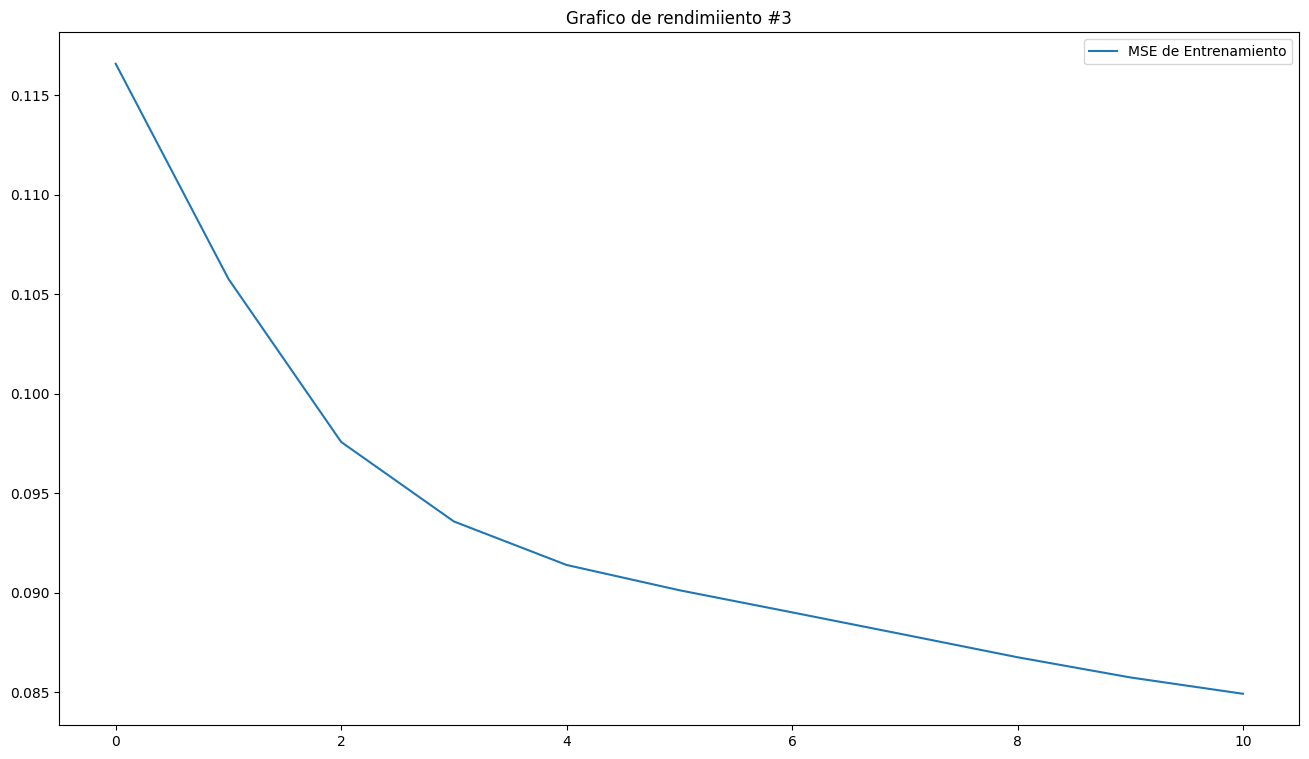

c:\GitHub\pronostico\pronostico\envprediccion\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


ValueError: math domain error

In [16]:

#El Core del sistema
with get_sqlconnection(sql_server) as cursor:
    datos = pd.read_sql_query(query, cursor)

    datos2 = pd.read_sql_query(query2,cursor)
    #habra casos donde el tiempo entregado sea ej 2020-12-31 00:00:00:00
    # Por lo que es conveniente que de todas maneras, hacer un tratamiento de datos para extraer la información
    # datos = format_to_date(datos)
    datos2 = set_index_datetime(datos2)
    datos = set_index_datetime(datos)
    # datos = format_to_date(datos)
    
    #Luego haremos el tratamiento e datos
    # datos.plot()
    print(datos.index)
    print(datos.describe())

    #Predicción de acuerdo a la oultima fecha registrada que fue en el 2020-12-31
    # Convertiremos la fecha en un objeto date
    # for i in range(len(datos)):
    #     datos['sales_date'][i] = datetime.strptime(str(datos['sales_date'][i])[:7], '%Y-%m-%d')
    # print(str(datos.index.max()))
    first_day = datetime.strptime(str(datos.index.min()), '%Y-%m') + relativedelta(months=1)
    first_day = first_day.year
    
    last_day = datetime.strptime(str(datos.index.max()), '%Y-%m') + relativedelta(months=1)

    #Predicción que se hará de acierdo a los pasos que se han definido 
    future_days = [last_day + relativedelta(months=i) for i in range(PASOS)]
    # future_days = [last_day + relativedelta(days=i) for i in range(1, PASOS+1)]
    # print(future_days)

    #Reesctructuramos los datos que se han obtenido, tomando solo los ultimos 10 digitos
    #future_days = [str(i)[:10] for i in future_days]
    for i in range(len(future_days)):
        future_days[i] = str(future_days[i])[:7]
        # future_days[i] = str(future_days[i])[:10]
    print(future_days)

    #Cremos un arreglo para poder tomar todas las fechas
    #Que servirá para predecir fechas futuras
    future_data = pd.DataFrame(future_days)
    future_data.columns = ['fecha']
    

    #Creamos un modelo de datos
    model = crear_modeloFF()
    data = []
    for column in datos.columns:
        data = datos.filter([column])
        data.set_index(datos.index, inplace=True)
        data = eliminar_anomalias(data)
        x_train, y_train, x_val, y_val, scaler, values = create_x_y_train(data)
        model, x_test = entrenar_modelo(x_train, y_train, x_val, y_val, scaler, values, data, model)
        results = []
        for i in range(PASOS):
            parcial = model.predict(x_test)
            results.append(parcial[0])
            x_test = agregarNuevoValor(x_test, parcial[0])
        adimen = [x for x in results]
        inverted = scaler.inverse_transform(adimen)
        # y_pred = pd.DataFrame(inverted.astype(int))
        future_data[column]= inverted.astype(int)
    future_data = set_index_datetime(future_data)



In [ ]:
print(datos)
datos

In [ ]:
# print(future_data)
# future_data.plot()

In [ ]:
    datos = datos2
    datos.index = pd.to_datetime(datos2.index)
    future_data.index = pd.to_datetime(future_data.index)

    #Graficar los dataframes
    plt.plot(datos.index, datos['TotalVentas'],label='Historial {p0} - {p1}'.format(p0=str(first_day),p1=str(last_day.year-1)))
    # plt.plot(future_data.index, future_data['TotalVentas'],label='Predicción 2021 - 2022')
    # xtics = data.index.union(future_data.index)[::8]

    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de productos vendidos')
    plt.title('Historial de la demanda {p0} - {p1}'.format(p0=str(first_day),p1=str(last_day.year)))
    


    plt.legend()
    plt.show()
    # future_data

In [ ]:
    #Graficar los dataframes
    plt.plot(datos.index, datos['TotalVentas'],label='Historial {p0} - {p1}'.format(p0=str(first_day), p1= str(last_day.year-1)))
    plt.plot(future_data.index, future_data['TotalVentas'],label='Predicción {p0}'.format(p0=str(last_day.year)))
    # xtics = data.index.union(future_data.index)[::8]

    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de productos vendidos')
    plt.title('Predicción de la demanda global por meses para el {p0}'.format(p0=str(last_day.year)))
    


    plt.legend()
    plt.show()
    future_data